## Agentic RAG

### Load API Keys

In [1]:
import os
from dotenv import load_dotenv

OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

### Setup Langsmith Tracking and API Key

In [2]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_PROJECT"]="AGENTIC_RAG"

## Load LLM model from OpenAI

In [3]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4.1-nano",
                    api_key=OPENAI_API_KEY,
                    temperature=0.5,
                    max_tokens=512 )

### Test LLM 

In [4]:
test_llm_response=llm.invoke("What is Large Language Models")
test_llm_response.content

"Large Language Models (LLMs) are advanced artificial intelligence systems designed to understand, generate, and interpret human language. They are built using deep learning techniques, particularly neural networks with vast numbers of parameters, enabling them to capture complex patterns and nuances in text data. Examples include models like GPT-3, GPT-4, and others developed by various organizations.\n\nKey features of LLMs include:\n- **Extensive Training Data:** They are trained on massive datasets comprising books, articles, websites, and other text sources to learn language structures, facts, and contextual information.\n- **Natural Language Understanding and Generation:** They can perform tasks such as answering questions, writing essays, translating languages, summarizing content, and more.\n- **Context Awareness:** LLMs can consider large portions of text to generate coherent and contextually relevant responses.\n- **Versatility:** They are used in numerous applications, inclu

## Load Text embedding model from OpenAI


In [5]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

### Test Embedding model

In [6]:
embedding_vector=embedding_model.embed_query("What is Large Language Models")

In [7]:
len(embedding_vector)

1536

## Load CSV data

In [8]:
import pandas as pd

df = pd.read_csv("sample_docs/ElectroTV_Sales_Report_2024.csv")
df.head()

,order_id,date,product_name,units_sold,unit_price_inr,total_sales_inr,sales_region,sales_channel
0,ORD00165,2024-11-02,ElectroTV E32 Smart,2,14999,29998,Central,Online
1,ORD00028,2024-01-06,ElectroTV E32 Smart,3,14999,44997,Central,Distributor
2,ORD00451,2024-03-04,ElectroTV E32 Smart,3,14999,44997,Central,Retail Store
3,ORD00240,2024-08-25,ElectroTV E32 Smart,4,14999,59996,Central,Retail Store
4,ORD00460,2024-03-13,ElectroTV E32 Smart,4,14999,59996,Central,Online


In [9]:
def get_dataframe_schema(df: pd.DataFrame) -> str:
    """
    Returns a readable schema description of the dataframe
    for use in LLM prompts.
    """
    lines = []
    for col, dtype in df.dtypes.items():
        lines.append(f"- {col} ({dtype})")
    return "\n".join(lines)


In [10]:
print(get_dataframe_schema(df))

- order_id (object)
- date (object)
- product_name (object)
- units_sold (int64)
- unit_price_inr (int64)
- total_sales_inr (int64)
- sales_region (object)
- sales_channel (object)


In [11]:
def clean_llm_code(code: str) -> str:
    """
    Remove markdown formatting (```python ... ```) from LLM-generated code
    so it can be safely executed with exec().
    """
    if not code:
        return ""

    code = code.strip()

    # Remove opening ```python or ```
    if code.startswith("```"):
        code = code.split("```", 1)[1]

    # Remove closing ```
    if code.endswith("```"):
        code = code.rsplit("```", 1)[0]

    return code.strip()


## Tool 1: Data Analyst tool

In [12]:
from langchain.tools import tool

@tool
def data_analyst_tool(question: str) -> str:
    """
    Use data_analyst_tool to answer analytical and numerical questions
    based on the sales CSV data.

    This tool should be used when the question requires:
    - unique list of products
    - cheapest, costliest products
    - aggregation (sum, average, count)
    - filtering (by product, sales, revenue, region, channel, date)
    - comparisons or rankings
    - any computation over the full sales 
    """

    schema = get_dataframe_schema(df)

    prompt = f"""
You are a data analyst working with a pandas DataFrame named `df`.

DataFrame schema:
{schema}

Write pandas code to answer the question.
Rules:
- Use ONLY the columns listed above
- Use ONLY the dataframe `df`
- Assign the final answer to a variable named `result`
- Do NOT print anything
- Do NOT explain the code
- Return ONLY Python code (no markdown, no backticks)

Question:
{question}
"""

    raw_code = llm.invoke(prompt).content
    code = clean_llm_code(raw_code)

    # DEBUG: print generated pandas code
    #print("\n[DEBUG] Generated pandas code:\n")
    #print(code)
    #print("\n" + "-" * 60 + "\n")

    local_vars = {}
    try:
        exec(code, {"df": df, "pd": pd}, local_vars)
        return str(local_vars["result"])
    except Exception as e:
        return (
            f"Error executing generated code:\n{e}\n\n"
            f"Generated code:\n{code}"
        )


## Load PDF data

In [13]:
from langchain_community.document_loaders import PyPDFLoader

loader=PyPDFLoader(file_path="sample_docs/ElectroTV.pdf")

pdf_data = loader.load()


In [14]:
print(pdf_data[0].metadata['source'])

sample_docs/ElectroTV.pdf


## Build Vector Store for PDF QnA


### Document Splitting

In [15]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100)

pdf_chunks = text_splitter.split_documents(pdf_data)


In [16]:
len(pdf_chunks)

30

### Add ids to chunks

In [17]:
from uuid import uuid4

uuids = [str(uuid4()) for _ in range(len(pdf_chunks))]

In [18]:
len(uuids)

30

In [19]:
uuids[:5]

['354eb253-3c0e-4530-8fec-b73988f3951d',
 '7fdc006e-333a-491d-89e2-f2f259dd3bcd',
 '4040365e-b10d-4818-9f01-855546ce2e2d',
 '44ee38af-bc99-468b-8a62-6e1dcd6e51ad',
 'ac3fd365-5928-4a66-aa44-b758fc84e346']

### Vector Store for PDF QNA

In [20]:
from langchain_chroma import Chroma

pdf_chunk_vector_store = Chroma(
    collection_name="ElectroTV_PDF_QNA",
    embedding_function=embedding_model,
    persist_directory="/home/abhishek/ad-workspace/chroma_db/ElectroTV/PDF_QNA",
)

In [21]:
pdf_chunk_vector_store.add_documents(documents=pdf_chunks, ids=uuids)

['354eb253-3c0e-4530-8fec-b73988f3951d',
 '7fdc006e-333a-491d-89e2-f2f259dd3bcd',
 '4040365e-b10d-4818-9f01-855546ce2e2d',
 '44ee38af-bc99-468b-8a62-6e1dcd6e51ad',
 'ac3fd365-5928-4a66-aa44-b758fc84e346',
 'e24155a0-271d-4777-9c68-ace67f0d54a3',
 '2762f970-da27-4cf1-8768-8e1edfa76176',
 '0164d846-0bed-4aba-97db-0ff4c6702d0a',
 '0f69fb8c-a83d-4cda-92a9-976e77380bc4',
 '6c130a2a-c018-4dbe-aae4-d3fe73341f0f',
 '45a5885e-627d-4d1a-9c21-5422d9bb3f77',
 '0d40007c-207b-4c6f-be08-d82a6546f133',
 '6198aa2b-0e23-4e8a-9ee2-07b81fe4d76d',
 'df66e4f5-510c-4c40-9153-81f28cbb346d',
 'cd7189da-d890-405c-8748-516ffa50276c',
 '7c0b11ef-bd31-48bb-b337-f69210875593',
 '272cb644-b89a-4697-b98d-902b37a1e62f',
 '00f5a24b-f3ec-4022-8d8f-77550ad1cf3d',
 '0e23f60c-42fb-4994-9d53-0cc9eb43edfb',
 'd429bff5-ef0f-4084-adfe-7e5b5441d1bb',
 'ad32f0ba-5a11-4ecc-be32-788a3a1eebbd',
 'be650cb1-d05c-4b4b-9956-cc3607864054',
 'a98e0e94-d07e-4aa2-a703-c17b32c23bcf',
 'ef5d4e02-6b44-4d23-a36f-c8bd5f01e7b7',
 '3a8d3762-85ac-

### PDF QNA Retriever

In [22]:
pdf_qna_retriever = pdf_chunk_vector_store.as_retriever(search_kwargs={"k": 15})

## Tool 2: PDF QNA tool

In [23]:
from langchain.tools import tool

@tool
def pdf_qna_tool(question: str) -> str:
    """
    Use pdf_qna_tool tool when the question involves:
    - general questions, explanations,
    - summaries based on the PDF content.
    - simple factual information from the PDF
    - locations, definitions, descriptions
    - information about the company and offices
    - Basic product information

    """
    docs = pdf_qna_retriever.invoke(question)
    context = "\n".join(d.page_content for d in docs)

    prompt = f"""
Answer the question using ONLY the context below.

Context:
{context}

Question:
{question}
"""

    return llm.invoke(prompt).content


## Tool 3: PDF Reasoning Tool

### Helper functions

In [24]:
def extract_items(question: str) -> list[str]:
    prompt = f"""
From the question below, extract the names of the items being discussed.
Return ONLY a Python list of strings.

Question:
{question}
"""
    response = llm.invoke(prompt).content
    return eval(response)


In [25]:
from langchain.tools import tool

@tool
def pdf_reasoning_tool(question: str) -> str:
    """
    Use 'pdf_reasoning_tool' when the question involves:
    - product comparisons (difference, vs, versus)
    - pros and cons
    - multi-product or multi-item analysis
    - reasoning across multiple sections of the PDF
    """
    

    # Step 1: Extract items involved
    items = extract_items(question)

    # Step 2: Retrieve context for EACH item independently
    item_contexts = {}

    for item in items:
        docs = pdf_qna_retriever.invoke(item)
        item_contexts[item] = "\n".join(d.page_content for d in docs)

    # Build context block OUTSIDE f-string
    context_blocks = []
    for item, ctx in item_contexts.items():
        block = (
            f"{item} information:\n"
            f"{ctx}\n"
        )
        context_blocks.append(block)

    combined_context = "\n".join(context_blocks)

    # Step 3: Reason over aligned contexts
    reasoning_prompt = f"""
You are performing a reasoning task using the information below.

{combined_context}

Question:
{question}

Instructions:
- Base your answer ONLY on the provided information
- Be structured and explicit
- Clearly compare attributes
"""

    return llm.invoke(reasoning_prompt).content


## Agent

In [26]:
from langchain.agents import create_agent

system_prompt = """
You are a helpful and intelligent assistant that answers questions using tools.

Single / Multiple tools may be used to retrieve the correct answer    

If the answer cannot be determined from the available tools, say clearly that "I don't know". Do not hallucinate.

Please use bullet points & tables wherever possible in the answers

"""


agent = create_agent(llm, tools=[data_analyst_tool, pdf_qna_tool, pdf_reasoning_tool], system_prompt=system_prompt)

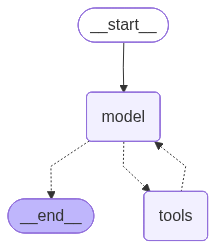

In [27]:
agent

## Ask Agent Function

In [28]:
def ask_agent(question: str, debug: bool = False):
    """
    Send a user question to the agent.

    Parameters:
    - question (str): user query
    - debug (bool): 
        - False (default): return only final answer
        - True: print full agent reasoning, tool calls, and messages

    Returns:
    - final answer (str)
    """

    input_message = {
        "role": "user",
        "content": question,
    }

    final_answer = None

    for step in agent.stream(
        {"messages": [input_message]},
        stream_mode="values",
    ):
        last_message = step["messages"][-1]

        # Show everything only in debug mode
        if debug:
            last_message.pretty_print()

        # Capture final AI response (ignore tool messages)
        if last_message.type == "ai" and last_message.content:
            final_answer = last_message.content

    return final_answer


## Question & Answer

### Question-1

In [29]:
question = "Where is the head office of ElectroTV"
answer = ask_agent(question)

print(answer)

The head office of ElectroTV is located at ElectroTV Tower, Plot No. 42, Tech Park Avenue, Sector 18, Gurugram – 122015, Haryana, India.


### Question-2

In [30]:
question = "How many regional officies does ElectroTV has and give me their contact numbers"
answer = ask_agent(question)

print(answer)

ElectroTV has four regional offices. Their contact numbers are:
- North Region Office: +91-120-678-2345
- South Region Office: +91-80-5123-7788
- East Region Office: +91-33-4098-1122
- West Region Office: +91-22-4455-9900


### Question-3

In [34]:
question = "How many Televion models are launched by ElectroTV so far. List down all of them"
answer = ask_agent(question)

print(answer)

ElectroTV has launched a total of 10 television models. They are:

1. ElectroTV E32 Smart  
2. ElectroTV E40 Smart  
3. ElectroTV E43 Smart  
4. ElectroTV E50 Pro  
5. ElectroTV E55 Pro+  
6. ElectroTV E58 Vision  
7. ElectroTV E65 Cinema  
8. ElectroTV E75 Cinema Max  
9. ElectroTV Q55 Ultra  
10. ElectroTV Q65 Ultra


### Question-4

In [35]:
question = "Which ElectroTV products are QLED televisions and what are their listed prices?"
answer = ask_agent(question)

print(answer)

The ElectroTV products that are QLED televisions are:
- ElectroTV Q55 Ultra
- ElectroTV Q65 Ultra

Their listed prices are:
- 55-inch QLED 4K: ₹54,999
- 65-inch QLED 4K: ₹69,999


### Question-5

In [36]:
question = "What is the phone number and email address of the ElectroTV Head Office?"
answer = ask_agent(question)

print(answer)

The phone number of the ElectroTV Head Office is +91-11-4567-8900, and the email address is corporate@electrotv.com.


### Question-6

In [37]:
question = "How many ElectroTV regional offices are there ? List them with contact details"
answer = ask_agent(question)

print(answer)

There are four ElectroTV regional offices with the following contact details:

| Region | Address | Phone | Email |
|---------|---------|--------|--------|
| North | 2nd Floor, Orion Business Center, Noida Sector 62, Uttar Pradesh – 201309 | +91-120-678-2345 | north.sales@electrotv.com |
| South | Sigma Tech Plaza, 5th Floor, Whitefield Main Road, Bengaluru – 560066, Karnataka | +91-80-5123-7788 | south.support@electrotv.com |
| West | Apex Commercial Complex, Andheri East, Mumbai – 400069, Maharashtra | +91-22-4455-9900 | west.sales@electrotv.com |
| East | Infinity IT Park, Block B, Salt Lake Sector V, Kolkata – 700091, West Bengal | +91-33-4098-1122 | east.support@electrotv.com |


### Question-7

In [38]:
question = "Which ElectroTV models priced below ₹50,000 are available, and how many total units of these models were sold in 2024?"
answer = ask_agent(question)

print(answer)

The ElectroTV models priced below ₹50,000 are:
- ElectroTV E32 Smart
- ElectroTV E40 Smart
- ElectroTV E43 Smart
- ElectroTV E50 Pro
- ElectroTV E55 Pro+
- ElectroTV E58 Vision

The total units of these models sold in 2024 are 2,274 units.


### Question-8

In [39]:
question = "Which ElectroTV product generated the highest total revenue across all sales records?"
answer = ask_agent(question)

print(answer)


The ElectroTV products with their total revenue across all sales records are as follows:

| Product Name            | Total Revenue (INR) |
|-------------------------|---------------------|
| ElectroTV E32 Smart    | 4,814,679           |
| ElectroTV E40 Smart    | 6,359,682           |
| ElectroTV E43 Smart    | 10,924,525          |
| ElectroTV E50 Pro      | 16,624,525          |
| ElectroTV E55 Pro+     | 14,490,663          |
| ElectroTV E58 Vision   | 16,703,652          |
| ElectroTV E65 Cinema   | 30,659,489          |
| ElectroTV E75 Cinema Max | 43,349,490       |
| ElectroTV Q55 Ultra     | 20,899,620          |
| ElectroTV Q65 Ultra     | 24,009,657          |

The product with the highest total revenue is **ElectroTV E75 Cinema Max** with INR 43,349,490.


### Question-9

In [42]:
question = "What is the total revenue of Central region in 2024?"
answer = ask_agent(question)

print(answer)

The total revenue of the Central region in 2024 is $35,990,179.


### Question-10

In [43]:
question = "Which ElectroTV products are marketed for home cinema use?"
answer = ask_agent(question)

print(answer)

The ElectroTV products marketed for home cinema use are:
- ElectroTV E65 Cinema
- ElectroTV E75 Cinema Max


### Question-11

In [44]:
question = "Which ElectroTV regional office should a customer in Bengaluru contact, and what are the contact details?"
answer = ask_agent(question)

print(answer)

A customer in Bengaluru should contact the ElectroTV regional office in the South region. The contact details are:

- Phone: +91-80-5123-7788
- Email: south.support@electrotv.com


### Question-12

In [45]:
question = "For E32 Smart model, Give me the following details: Price, Features "
answer = ask_agent(question)

print(answer)

The details for the E32 Smart model are as follows:

- **Price:** ₹14,999
- **Features:**
  - Compact HD-ready display suitable for bedrooms and small living spaces
  - Optimized for streaming and cable TV
  - Energy-efficient design
  - Android TV operating system
  - HD Ready display
  - 20W sound output


### Question-13

In [46]:
question = "How many units of ElectroTV E32 Smart are sold in North region in the year 2024 "
answer = ask_agent(question)

print(answer)

A total of 37 units of ElectroTV E32 Smart were sold in the North region in 2024.


### Question-14

In [47]:
question = "What are the differences between ElectroTV E55+ Pro and ElectroTV E58 Vision?"
answer = ask_agent(question)

print(answer)

The differences between ElectroTV E55+ Pro and ElectroTV E58 Vision are as follows:

| Feature                     | ElectroTV E55+ Pro                             | ElectroTV E58 Vision                          |
|------------------------------|------------------------------------------------|------------------------------------------------|
| Type                         | Premium 4K TV                                | Large-format 4K UHD TV                        |
| Screen Size                  | 55-inch                                       | 58-inch                                       |
| Features                     | Designed for immersive viewing, enhanced audio | Optimized for streaming and sports content, modern slim-bezel design |
| Picture Quality              | 4K UHD with HDR10+                            | 4K UHD with Wide Color Gamut, MEMC           |
| Audio                        | 40W Sound Output                              | Not specified                       

### Question-15

In [48]:
question = "Which is the cheapest and costliest ElectroTV models. Mention the model names and prices?"
answer = ask_agent(question)

print(answer)

The cheapest ElectroTV model is the **ElectroTV E32 Smart** priced at **14999**.
The costliest ElectroTV model is the **ElectroTV E75 Cinema Max** priced at **84999**.
